In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
%%time
mnist = fetch_openml('mnist_784', version=1,cache=True)
mnist.keys()
print("time for fetch")

time for fetch
CPU times: user 1min 5s, sys: 2.43 s, total: 1min 7s
Wall time: 1min 8s


In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

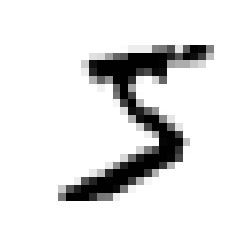

In [4]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [5]:
def shiftx(img,n_sh,dire):
    """
    function to shift image in four direction right or left or up or down
    :param img is image need to shift 
    :param n_sh is number need to shift
    :param dire is direction to shift
    """
    
    img_n=img.reshape(28,28)
    row,col =img_n.shape
    iimg = np.zeros([row,col])
    
    if dire== 'r':
        for i in range(row):
            for j in range(col-n_sh):
                iimg[i][j+n_sh]=img_n[i][j]
                
    elif dire=='l':
        for i in range(row):
            for j in range(col-n_sh):
                iimg[i][j]=img_n[i][j+n_sh]
                
    elif dire=='u':
        for i in range(row-n_sh):
            for j in range(col):
                iimg[i+n_sh][j]=img_n[i][j]
    elif dire=='d':
        for i in range(row-n_sh):
            for j in range(col):
                iimg[i][j]=img_n[i+n_sh][j]
                
    else:
        raise RuntimeError("please enter 'l' to left  or 'r' to right or 'd'to down or 'u' to up ")
        return None
    
    return iimg.reshape([-1])

In [6]:
%%time
xxc=shiftx(some_digit,10,'u')
# shift(some_digit,10,'u').shape

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.33 ms


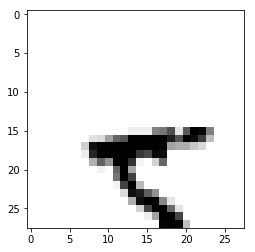

In [7]:
plt.imshow(xxc.reshape(28,28), cmap = mpl.cm.binary, interpolation="nearest")

In [8]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

In [9]:
%%time
xx=shift_image(some_digit,-10,0)
# plt.imshow(xx.reshape(28,28), cmap = mpl.cm.binary, interpolation="nearest")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.3 ms


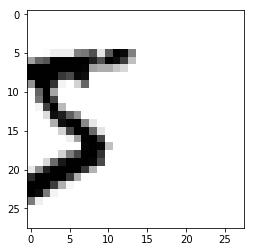

In [10]:
plt.imshow(xx.reshape(28,28), cmap = mpl.cm.binary, interpolation="nearest")

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [12]:
%%time
ext_x1 = [img for img in X_train]
ext_y1= [label for label in y_train]
for i in range(len(X_train)):
    ext_x1.append(shiftx(X_train[i],1,'r'))
    ext_y1.append(y_train[i])
    ext_x1.append(shiftx(X_train[i],1,'l'))
    ext_y1.append(y_train[i])
    ext_x1.append(shiftx(X_train[i],1,'u'))
    ext_y1.append(y_train[i])
    ext_x1.append(shiftx(X_train[i],1,'d'))
    ext_y1.append(y_train[i])

CPU times: user 4min 10s, sys: 3.71 s, total: 4min 14s
Wall time: 4min 17s


In [13]:
len(ext_y1)

300000

In [14]:
%%time
ext_x = [img for img in X_train]
ext_y= [label for label in y_train]

for i, j in ((-1, 0), (0,-1), (0, 1), (1, 0)):
    for img, label in zip(X_train, y_train):
        ext_x.append(shift_image(img, i, j))
        ext_y.append(label)
print("time is take for data augmentation ")

time is take for data augmentation 
CPU times: user 1min 48s, sys: 3.39 s, total: 1min 51s
Wall time: 1min 53s


In [15]:
ext_x1 = np.array(ext_x1)
ext_y1 = np.array(ext_y1)

In [16]:
ext_x1.shape

(300000, 784)

In [17]:
%%time
scaler = StandardScaler()
X_t_s = scaler.fit_transform(X_train.astype(np.float64))
X_test_s = scaler.fit_transform(X_test.astype(np.float64))
ext_xs = scaler.fit_transform(ext_x1.astype(np.float64))

CPU times: user 31.4 s, sys: 18 s, total: 49.4 s
Wall time: 22.3 s


# SGDClassifier

SGDClassifier Before data augmentation

In [21]:
# %%time
# sgd_clf = SGDClassifier(random_state=42,n_jobs=-1)
#  y_t_p = cross_val_predict(sgd_clf, X_t_s, y_train, cv=3)

In [20]:
%%time
sgd_clf = SGDClassifier(random_state=42,n_jobs=-1)
sgd_clf.fit(X_t_s, y_train)
y_t_p = sgd_clf.predict(X_t_s[100:1000])

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


CPU times: user 17.7 s, sys: 24 ms, total: 17.7 s
Wall time: 6.02 s


In [21]:
from sklearn.metrics import accuracy_score
print(" training accuracy  Before data augmentation",str(accuracy_score(y_train[100:1000], y_t_p)))

 training accuracy  Before data augmentation 0.9033333333333333


In [24]:
y_ts_p = sgd_clf.predict(X_test_s)
print(" testing accuracy  Before data augmentation",str(accuracy_score(y_test, y_ts_p)))

 testing accuracy  Before data augmentation 0.9121


### SGDClassifier After data augmentation

In [22]:
# %%time
# sgd_clf_ext = SGDClassifier(random_state=42,n_jobs=-1)
# ext_y_t_p = cross_val_predict(sgd_clf_ext, ext_xs, ext_y1, cv=3)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left un

CPU times: user 1min 12s, sys: 3.29 s, total: 1min 16s
Wall time: 28.5 s


In [25]:
%%time
sgd_clf_ext = SGDClassifier(random_state=42,n_jobs=-1)
sgd_clf_ext.fit(ext_xs, ext_y1)
ext_y_t_p = sgd_clf_ext.predict(ext_xs[1400:10000])

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


CPU times: user 1min 32s, sys: 164 ms, total: 1min 32s
Wall time: 29.7 s


In [26]:
print("training accuracy After data augmentation",str(accuracy_score(ext_y1[1400:10000], ext_y_t_p)))

training accuracy After data augmentation 0.9197674418604651


In [45]:
y_ts_p_ext = sgd_clf_ext.predict(X_test_s)
print(" testing accuracy  After data augmentation",str(accuracy_score(y_test, y_ts_p_ext)))

 testing accuracy  After data augmentation 0.915


# RandomForestClassifier


In [29]:
%%time
from sklearn.ensemble import RandomForestClassifier
# forest_clf = RandomForestClassifier(random_state=42)
# forest_clf.fit(X_t_s,y_train)

CPU times: user 32 ms, sys: 12 ms, total: 44 ms
Wall time: 40.3 ms


In [25]:
# %%time
# forest_clf = RandomForestClassifier(random_state=42,n_jobs=-1)
# cc=cross_val_score(forest_clf,X_t_s,y_train, cv=3, scoring="accuracy")

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 10.3 s, sys: 1.26 s, total: 11.6 s
Wall time: 10 s


In [26]:
# print("accuracy Before data augmentation",str(np.mean(cc)))

accuracy Before data augmentation 0.9413834445747166


In [38]:
%%time
forest_clf = RandomForestClassifier(random_state=42,n_jobs=-1)
forest_clf.fit(X_t_s, y_train)
y_f_t_p = forest_clf.predict(X_t_s[100:2000])

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 16.3 s, sys: 8 ms, total: 16.3 s
Wall time: 5.6 s


In [39]:
print("training accuracy Before data augmentation",str(accuracy_score(ext_y1[100:2000], y_f_t_p)))

training accuracy Before data augmentation 0.9994736842105263


In [44]:
y_fts_p = forest_clf.predict(X_test_s)
print(" testing accuracy  Before data augmentation",str(accuracy_score(y_test, y_fts_p)))

 testing accuracy  Before data augmentation 0.8765


### RandomForestClassifier After data augmentation

In [27]:
# %%time
# forest_clf_exd = RandomForestClassifier(random_state=42,n_jobs=-1)
# cc_ext=cross_val_score(forest_clf_exd,ext_xs,ext_y1, cv=3, scoring="accuracy")

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 14.8 s, sys: 6.17 s, total: 20.9 s
Wall time: 39.8 s


In [28]:
# print("accuracy After data augmentation",str(np.mean(cc_ext)))

accuracy After data augmentation 0.9538132251936576


In [41]:
%%time
forest_clf_exd = RandomForestClassifier(random_state=42,n_jobs=-1)
forest_clf_exd.fit(ext_xs, ext_y1)
y_f_t_p_ext = forest_clf_exd.predict(ext_xs[100:2000])

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 3min 2s, sys: 1.85 s, total: 3min 4s
Wall time: 59.8 s


In [42]:
print("training accuracy After data augmentation",str(accuracy_score(ext_y1[100:2000], y_f_t_p_ext)))

training accuracy After data augmentation 0.9994736842105263


In [46]:
y_fts_p_ext = forest_clf_exd.predict(X_test_s)
print("testing accuracy After data augmentation",str(accuracy_score(y_test, y_fts_p_ext)))

testing accuracy After data augmentation 0.893


#  k-nearest neighbors

In [29]:
# %%time
# knn_clf = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
#                      metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
#                      weights='uniform')
# # knn_clf.fit(X_t_s,y_train)
# ck=cross_val_score(knn_clf,X_t_s,y_train, cv=3, scoring="accuracy")
# print("accuracy Before data augmentation",str(np.mean(ck)))

accuracy Before data augmentation 0.9403669636870157
CPU times: user 52.4 s, sys: 1.24 s, total: 53.7 s
Wall time: 24min 6s


In [50]:
%%time
from sklearn.model_selection import GridSearchCV
param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]
knn_clf = KNeighborsClassifier(n_jobs=-1)
# grid_search = GridSearchCV(knn_clf, param_grid, cv=3, verbose=3)
knn_clf.fit(X_t_s,y_train)
y_k_pred = knn_clf.predict(X_t_s[500:3000])

CPU times: user 14min 31s, sys: 1.13 s, total: 14min 32s
Wall time: 6min


In [51]:
print("training accuracy Before data augmentation",str(accuracy_score(y_train[500:3000], y_k_pred)))

training accuracy Before data augmentation 0.958


In [52]:
%%time
y_ks_pred = knn_clf.predict(X_test_s)
print("testing accuracy Before data augmentation",str(accuracy_score(y_test, y_ks_pred)))

testing accuracy Before data augmentation 0.9423
CPU times: user 50min 12s, sys: 3.67 s, total: 50min 15s
Wall time: 13min 21s


### k-nearest neighbors After data augmentation

In [ ]:
# %%time
# knn_clf_ext = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
#                      metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
#                      weights='uniform')
# ck_e=cross_val_score(knn_clf_ext,ext_xs,ext_y1, cv=3, scoring="accuracy")
# print("accuracy After data augmentation",str(np.mean(ck_e)))

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [53]:
%%time
knn_clf_ext = KNeighborsClassifier(n_jobs=-1)
knn_clf_ext.fit(ext_xs, ext_y1)
y_k_pred_ext = knn_clf_ext.predict(ext_xs[500:3000])

CPU times: user 2h 40min 14s, sys: 14.9 s, total: 2h 40min 29s
Wall time: 1h 53min 56s


In [54]:
print("training accuracy After data augmentation",str(accuracy_score(ext_y1[500:3000], y_k_pred_ext)))

training accuracy After data augmentation 0.9852


In [78]:
%%time
y_ks_pred_ext = knn_clf_ext.predict(X_test_s[20:600])
print("testing accuracy Before data augmentation",str(accuracy_score(y_test[20:600], y_ks_pred_ext)))

testing accuracy Before data augmentation 0.9344827586206896
CPU times: user 37min 40s, sys: 3.06 s, total: 37min 43s
Wall time: 9min 28s


In [79]:
import dill
dill.dump_session('assi.db')